# Training a classifier with gaze features for calculating predictions of various activities

__UbiComp Assignment 02, Task 01:__
This third notebook trains a classifier with select features and corresponding labels.\
The features and labels are read from a given csv-file.

## Read data from a csv-file.

Note that the csv-file we are using here is generated by the FeatureCalculation Notebook.

In [1]:
import os
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

all_features_csv = os.path.join('/content/drive/MyDrive/UbiComp/Exercise2/Data/FeatureFiles/feature_list_all.csv')
df = pd.read_csv(all_features_csv)

Mounted at /content/drive


In [2]:
# Uncomment the following lines to see all columns of the csv file (i.e., the features and labels)
print("Columns of the CSV file are 19 features, label of the activity, duration or the timespan of the activity, and the ID of the participant:")
list(df.columns)

Columns of the CSV file are 19 features, label of the activity, duration or the timespan of the activity, and the ID of the participant:


['meanFix',
 'minFix',
 'maxFix',
 'varFix',
 'stdFix',
 'meanDis',
 'minDis',
 'maxDis',
 'varDis',
 'stdDisp',
 'freqDisPerSec',
 'number_of_blinks',
 'blinkMean',
 'blinkMin',
 'blinkMax',
 'blinkRate',
 'xDir',
 'yDir',
 'fixDensPerBB',
 'label',
 'duration',
 'participant_id']

In [3]:
from IPython.display import display

read_df = df[df.label == 'Reading']
inspect_df = df[df.label == 'Inspection']
search_df = df[df.label == 'Search']

#print("Sample reading data:")
#display(read_df[['meanFix', 'maxFix', 'varFix', 'xDir', 'yDir']].head(10))

#print("Sample inspection data:")
#display(inspect_df[['meanFix', 'maxFix', 'varFix', 'xDir', 'yDir']].head(10))

#print("Sample search data:")
#display(search_df[['meanFix', 'maxFix', 'varFix', 'xDir', 'yDir']].head(10))

## For the classification we used a modified version of [an SVM cassifier.](https://towardsdatascience.com/multiclass-classification-with-support-vector-machines-svm-kernel-trick-kernel-functions-f9d5377d6f02)
First, we need to include some libraries

In [4]:
#
#Importing the necessary packages and libaries
#
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt
import numpy as np

## Let's store the labels and six selected features (among nineteen as denoted in the csv file)

In [55]:
features = df[["meanFix", "maxFix", "varFix", "xDir", "yDir", "fixDensPerBB"]]
labels = df ['label']

In [63]:
#new features round 2
features = df[['meanFix',
 'minFix',
 'maxFix',
 'varFix',
 'stdFix',
 'meanDis',
 'minDis',
 'maxDis',
 'varDis',
 'stdDisp',
 'freqDisPerSec',
 'number_of_blinks',
 'blinkMean',
 'blinkMin',
 'blinkMax',
 'blinkRate',
 'xDir',
 'yDir',
 'fixDensPerBB',]]
labels = df ['label']

In [70]:
#new features round 3
features = df[['meanFix',
 'maxFix',
 'varFix',
 'stdFix',
 'meanDis',
 'varDis',
 'stdDisp',
 'freqDisPerSec',
 'xDir',
 'yDir',
 'fixDensPerBB']]
labels = df ['label']

In [77]:
#new features round 4
features = df[['meanFix',
 'maxFix',
 'varFix',
 'stdFix',
 'meanDis',
 'varDis',
 'stdDisp',
 'freqDisPerSec',
 'xDir',
 'yDir',
 'fixDensPerBB',
 'number_of_blinks',
 'blinkRate',
 'blinkMean']]

## This is how the features and labels look

In [12]:
print("Features:")
display(features.head(10))
print("Labels:")
display(labels.head(10))

Features:


,meanFix,maxFix,varFix,stdFix,meanDis,varDis,stdDisp,freqDisPerSec,xDir,yDir,fixDensPerBB,number_of_blinks,blinkRate,blinkMean
0,250.882353,666,16554.228164,128.663235,0.050347,0.001026,0.032029,3.4,0.484848,0.606061,369.479986,4,0.4,2291.500000
1,246.742857,900,23549.020168,153.456900,0.052125,0.000947,0.030780,3.5,0.529412,0.529412,363.711018,0,0.0,0.000000
2,237.257143,1067,36627.431933,191.382946,0.058595,0.002116,0.045998,3.5,0.441176,0.558824,266.246748,0,0.0,0.000000
3,293.137931,767,35208.551724,187.639419,0.047417,0.000828,0.028777,2.9,0.500000,0.500000,319.553727,0,0.0,0.000000
4,199.125000,566,12614.163462,112.312793,0.045997,0.000939,0.030645,4.0,0.589744,0.487179,305.832090,5,0.5,1899.800000
5,262.562500,867,36411.415323,190.817754,0.044003,0.000563,0.023737,3.2,0.516129,0.580645,236.757891,0,0.0,0.000000
6,204.175000,733,16987.430128,130.335836,0.051403,0.001306,0.036133,4.0,0.538462,0.512821,445.453567,0,0.0,0.000000
7,221.540541,733,19568.977477,139.889161,0.046934,0.000824,0.028712,3.7,0.583333,0.500000,538.273012,1,0.1,6266.000000
8,430.095238,2567,322794.690476,568.150236,0.046509,0.001470,0.038339,2.1,0.800000,0.450000,77.460002,3,0.3,3266.666667
9,227.805556,533,8651.246825,93.012079,0.048357,0.002175,0.046638,3.6,0.914286,0.457143,132.320562,8,0.8,1162.625000


Labels:


0    Inspection
1    Inspection
2    Inspection
3    Inspection
4    Inspection
5    Inspection
6    Inspection
7    Inspection
8       Reading
9       Reading
Name: label, dtype: object

## Let's normalize the features (i.e., each column indivudally)

In [49]:
scaler = MaxAbsScaler()
scaler.fit(features)
scaled = scaler.transform(features)
scaled_features = pd.DataFrame(scaled, columns=features.columns)
print("Normalized Features:")
display(scaled_features.head(10))

Normalized Features:


,meanFix,maxFix,varFix,stdFix,meanDis,varDis,stdDisp,freqDisPerSec,xDir,yDir,fixDensPerBB,number_of_blinks,blinkRate,blinkMean
0,0.412048,0.144783,0.013814,0.117533,0.439555,0.030128,0.173574,0.755556,0.527009,0.743802,0.238355,0.051282,0.051282,0.365645
1,0.405249,0.195652,0.019651,0.140181,0.455082,0.027823,0.166802,0.777778,0.575448,0.649733,0.234633,0.000000,0.000000,0.000000
2,0.389670,0.231957,0.030564,0.174826,0.511570,0.062137,0.249273,0.777778,0.479540,0.685829,0.171758,0.000000,0.000000,0.000000
3,0.481448,0.166739,0.029380,0.171407,0.413976,0.024320,0.155949,0.644444,0.543478,0.613636,0.206147,0.000000,0.000000,0.000000
4,0.327042,0.123043,0.010526,0.102597,0.401578,0.027580,0.166071,0.888889,0.641026,0.597902,0.197295,0.064103,0.064103,0.303143
5,0.431232,0.188478,0.030384,0.174310,0.384171,0.016547,0.128636,0.711111,0.561010,0.712610,0.152735,0.000000,0.000000,0.000000
6,0.335336,0.159348,0.014175,0.119061,0.448781,0.038343,0.195813,0.888889,0.585284,0.629371,0.287366,0.000000,0.000000,0.000000
7,0.363857,0.159348,0.016330,0.127787,0.409761,0.024209,0.155593,0.822222,0.634058,0.613636,0.347245,0.012821,0.012821,0.999840
8,0.706387,0.558043,0.269361,0.519000,0.406048,0.043166,0.207765,0.466667,0.869565,0.552273,0.049970,0.038462,0.038462,0.521249
9,0.374147,0.115870,0.007219,0.084966,0.422181,0.063877,0.252740,0.800000,0.993789,0.561039,0.085361,0.102564,0.102564,0.185515


In [78]:
# standard scaler
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()

scaled = scaler.fit_transform(features)


scaled_features = pd.DataFrame(scaled, columns=features.columns)
print("Standardized Features:")
display(scaled_features.head(10))


Standardized Features:


,meanFix,maxFix,varFix,stdFix,meanDis,varDis,stdDisp,freqDisPerSec,xDir,yDir,fixDensPerBB,number_of_blinks,blinkRate,blinkMean
0,-0.106753,-0.296820,-0.264446,-0.406209,-0.548305,-0.660088,-0.786512,0.628699,-0.715497,1.020680,0.565042,-0.989256,-0.989256,1.544437
1,-0.163175,0.320659,-0.162321,-0.123343,-0.428381,-0.677482,-0.828068,0.830574,-0.429143,0.208211,0.540060,-1.262032,-1.262032,-1.272616
2,-0.292467,0.761338,0.028625,0.309348,0.007885,-0.418525,-0.321949,0.830574,-0.996125,0.519973,0.118006,-1.262032,-1.262032,-1.272616
3,0.469198,-0.030302,0.007909,0.266638,-0.745854,-0.703917,-0.894674,-0.380680,-0.618137,-0.103550,0.348844,-1.262032,-1.262032,-1.272616
4,-0.812215,-0.560700,-0.321971,-0.592748,-0.841605,-0.679317,-0.832552,1.839953,-0.041462,-0.239446,0.289424,-0.921062,-0.921062,1.062901
5,0.052449,0.233578,0.025471,0.302899,-0.976048,-0.762574,-1.062287,0.224947,-0.514495,0.751279,-0.009691,-1.262032,-1.262032,-1.272616
6,-0.743382,-0.120021,-0.258121,-0.387127,-0.477049,-0.598093,-0.650031,1.839953,-0.370991,0.032346,0.894034,-1.262032,-1.262032,-1.272616
7,-0.506687,-0.120021,-0.220430,-0.278135,-0.778409,-0.704752,-0.896855,1.234326,-0.082653,-0.103550,1.295975,-1.193838,-1.193838,6.430483
8,2.335950,4.719537,4.206700,4.607812,-0.807083,-0.561690,-0.576679,-1.995686,1.309604,-0.633544,-0.699507,-1.057450,-1.057450,2.743257
9,-0.421294,-0.647781,-0.379830,-0.812946,-0.682487,-0.405393,-0.300676,1.032450,2.043982,-0.557830,-0.461941,-0.716480,-0.716480,0.156656


## Let's split the data and have two sets, one for training the model and one for testing it.

In [79]:
#feature_train, feature_test, label_train, label_test = train_test_split(features, labels, train_size=0.8, random_state = 0, stratify=labels)

# Uncomment the following line if you want to work with normalized features. You will note how the accuracy and confusion matrix changes
feature_train, feature_test, label_train, label_test = train_test_split(scaled_features, labels, train_size=0.8, random_state = 0, stratify=labels)

## We can work with different SVM-kernels:

In [ ]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo', probability=True).fit(feature_train, label_train)

rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo', probability=True).fit(feature_train, label_train)

poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo', probability=True).fit(feature_train, label_train)

sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo', probability=True).fit(feature_train, label_train)

In [80]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(feature_train, label_train)


RandomForestClassifier(random_state=42)

In [81]:
from sklearn.ensemble import GradientBoostingClassifier


gb = GradientBoostingClassifier(n_estimators=100, random_state=42)


gb.fit(feature_train, label_train)


GradientBoostingClassifier(random_state=42)

## Lets collect the predictions from test data. . .

In [19]:
linear_pred = linear.predict(feature_test)
poly_pred = poly.predict(feature_test)
rbf_pred = rbf.predict(feature_test)
sig_pred = sig.predict(feature_test)


NameError: ignored

In [82]:
#random forest
rf_pred = rf.predict(feature_test)
#gradient boost
gb_pred = gb.predict(feature_test)

## . . . and have a look at the accuracy of each one:

In [61]:
# retrieve the accuracy and print it for all 4 kernel functions
accuracy_lin = linear.score(feature_test, label_test)
accuracy_poly = poly.score(feature_test, label_test)
accuracy_rbf = rbf.score(feature_test, label_test)
accuracy_sig = sig.score(feature_test, label_test)


print("Accuracy Linear Kernel:", accuracy_lin)
print("Accuracy Polynomial Kernel:", accuracy_poly)
print("Accuracy Radial Basis Kernel:", accuracy_rbf)
print("Accuracy Sigmoid Kernel:", accuracy_sig)



NameError: ignored

In [83]:
#random forest
accuracy_rf = rf.score(feature_test, label_test)
#gradient boost
accuracy_gb = gb.score(feature_test, label_test)
print("Accuracy random forest:", accuracy_rf)
print("Gradient Boosting Classifier:", accuracy_gb)

Accuracy random forest: 0.8961038961038961
Gradient Boosting Classifier: 0.8441558441558441


## This is how the confusion matrix of each predictor looks like

In [ ]:
# creating a confusion matrix
cm_lin = confusion_matrix(label_test, linear_pred)
cm_poly = confusion_matrix(label_test, poly_pred)
cm_rbf = confusion_matrix(label_test, rbf_pred)
cm_sig = confusion_matrix(label_test, sig_pred)
cm_rf = confusion_matrix(label_test, rf_pred)
cm_gb = confusion_matrix(label_test, gb_pred)

print("CM Linear:")
print(cm_lin)
print("CM Polynomial:")
print(cm_poly)
print("CM Radial:")
print(cm_rbf)
print("CM Sigmoid:")
print(cm_sig)
print("CM RandomForest:")
print(cm_rf)
print("CM Gradient Boost:")
print(cm_gb)

CM Linear:
[[22  0  4]
 [ 1 25  0]
 [ 5  0 20]]
CM Polynomial:
[[23  0  3]
 [ 2 24  0]
 [ 6  1 18]]
CM Radial:
[[23  0  3]
 [ 0 25  1]
 [ 5  1 19]]
CM Sigmoid:
[[ 0 26  0]
 [ 0 26  0]
 [ 0 25  0]]
CM RandomForest:
[[25  0  1]
 [ 0 26  0]
 [ 7  0 18]]
CM Gradient Boost:
[[24  0  2]
 [ 1 24  1]
 [ 8  0 17]]


## A more colorful confusion matrix for the linear predictor

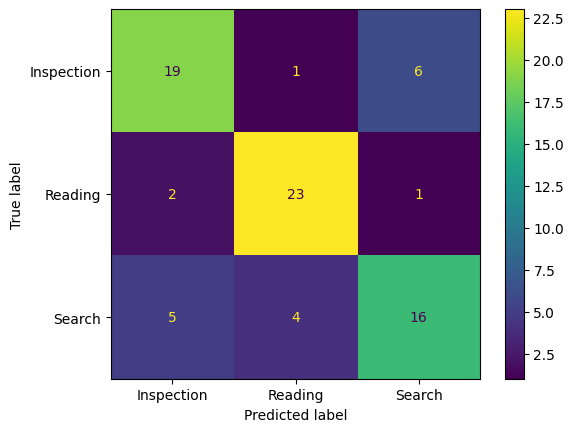

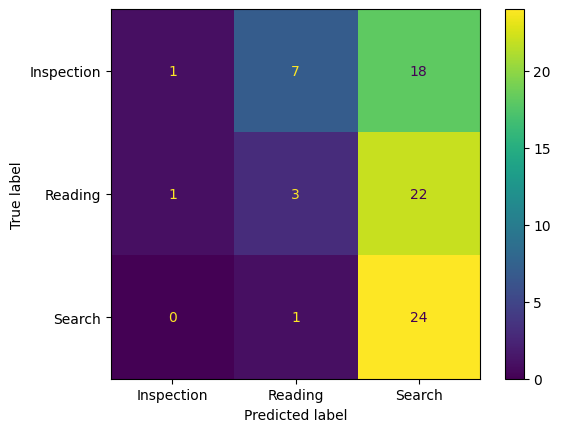

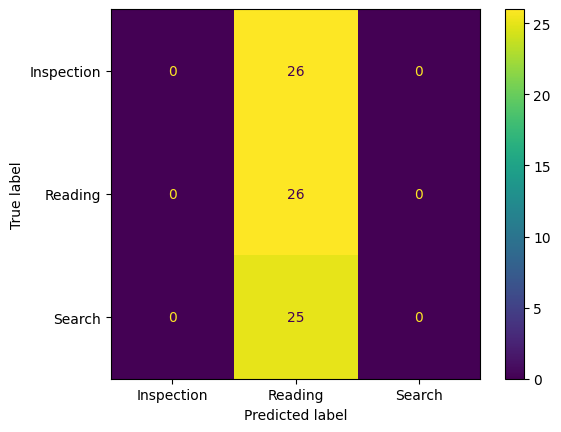

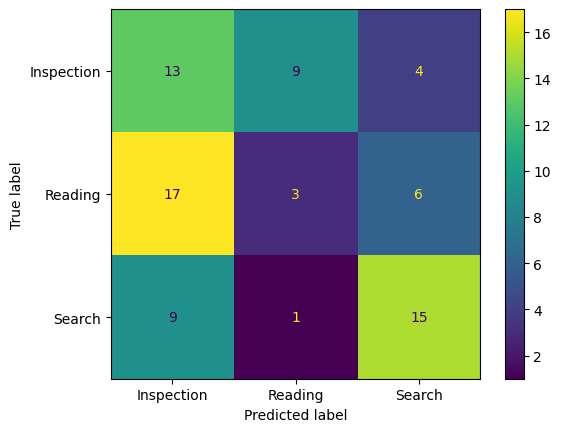

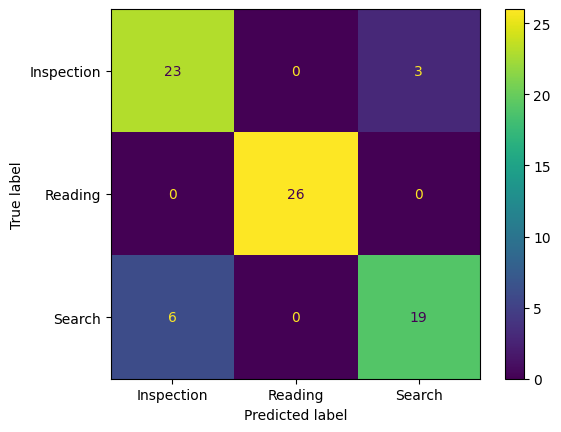

In [ ]:
ConfusionMatrixDisplay.from_estimator(linear, feature_test, label_test)
ConfusionMatrixDisplay.from_estimator(poly, feature_test, label_test)
ConfusionMatrixDisplay.from_estimator(rbf, feature_test, label_test)
ConfusionMatrixDisplay.from_estimator(sig, feature_test, label_test)
ConfusionMatrixDisplay.from_estimator(rf, feature_test, label_test)

## Finally, let's make a cross check

In [ ]:
feature_test.head()

,meanFix,minFix,maxFix,varFix,stdFix,meanDis,varDis,stdDisp,freqDisPerSec,xDir,yDir,fixDensPerBB
190,0.390237,-0.216218,0.146498,-0.011193,0.226486,1.090983,-0.187706,0.017000,-0.380680,-0.847630,0.275017,0.357149
298,0.597853,-0.216218,0.584539,0.135323,0.517272,0.860732,0.402346,0.685364,-0.986307,-0.232589,-1.163538,-0.568222
162,-0.600245,-0.216218,-0.734861,-0.347518,-0.684935,0.331592,-0.116600,0.109650,0.628699,-0.131334,0.378263,-0.763285
188,-0.727833,-0.216218,-0.647781,-0.288138,-0.480009,-1.083755,-0.706255,-0.900790,1.436201,-0.704972,-0.246791,0.112528
92,-0.674209,-0.216218,-0.381262,-0.232652,-0.312644,-0.571660,-0.402419,-0.295899,1.032450,0.208038,1.864999,-0.520898


In [ ]:
linear.predict(np.array(features.iloc[59]).reshape(1,-1))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array(['Inspection'], dtype=object)

## Let's detect the label (i.e., the activity) of some new features (i.e., that are extracted from a new stream of eye tracking data):

In [ ]:
print("New Feature:")
# NOTE that we use a particular feature from the test dataset but this can be replaced with new data e.g., that arrives online and was not included in training or testing the classifier
new_feature = feature_test.tail(2)
display(new_feature)

new_linear_pred = linear.predict_proba(new_feature)
new_linear_pred_2 = linear.predict(new_feature)
print("New Linear Prediction:")
display(new_linear_pred)
display(new_linear_pred_2)

new_poly_pred_2 = poly.predict(new_feature)
new_poly_pred = poly.predict_proba(new_feature)
print("New Poly Prediction:")
display(new_poly_pred)
display(new_poly_pred_2)

new_rbf_pred_2 = rbf.predict(new_feature)
new_rbf_pred = rbf.predict_proba(new_feature)
print("New RBF Prediction:")
display(new_rbf_pred)
display(new_rbf_pred_2)

new_sig_pred_2 = sig.predict(new_feature)
new_sig_pred = sig.predict_proba(new_feature)
print("New Sig Prediction:")
display(new_sig_pred)
display(new_sig_pred_2)

new_rf_pred_2 = rf.predict(new_feature)
new_rf_pred = rf.predict_proba(new_feature)
print("New rf Prediction:")
display(new_rf_pred)
display(new_rf_pred_2)

New Feature:


,meanFix,maxFix,varFix,xDir,yDir,fixDensPerBB
121,244.161290,600,15356.806452,0.833333,0.333333,106.653398
195,313.592593,734,25422.866097,0.769231,0.461538,123.174128


New Linear Prediction:


array([[0.06918933, 0.51783345, 0.41297722],
       [0.07704758, 0.79331888, 0.12963353]])

array(['Reading', 'Reading'], dtype=object)

New Poly Prediction:


array([[0.31205426, 0.32881882, 0.35912692],
       [0.31742002, 0.32997217, 0.35260781]])

array(['Search', 'Search'], dtype=object)

New RBF Prediction:


array([[0.33673633, 0.34016492, 0.32309875],
       [0.33673633, 0.34016492, 0.32309875]])

array(['Reading', 'Reading'], dtype=object)

New Sig Prediction:


array([[0.35948326, 0.32151289, 0.31900386],
       [0.36821423, 0.37385626, 0.25792951]])

array(['Inspection', 'Inspection'], dtype=object)

New rf Prediction:


array([[0.02, 0.97, 0.01],
       [0.  , 1.  , 0.  ]])

array(['Reading', 'Reading'], dtype=object)